In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

inspector.get_table_names()


['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_obs_date=session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first().date
last_obs_date

'2017-08-23'

In [14]:
year_ago = dt.datetime.strptime(last_obs_date, '%Y-%m-%d') - dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [15]:
# Perform a query to retrieve the data and precipitation scores
precip_year_data_df=pd.DataFrame(session.query(Measurement.date, func.avg(Measurement.prcp)).\
                                         filter(Measurement.date >= year_ago).\
                                         group_by(Measurement.date).all(), columns=['Date', 'Precipitation'])

precip_year_data_df.set_index('Date', inplace=True)
#precip_year_data_df.sort_values(by=['date'])
precip_year_data_df.head()

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


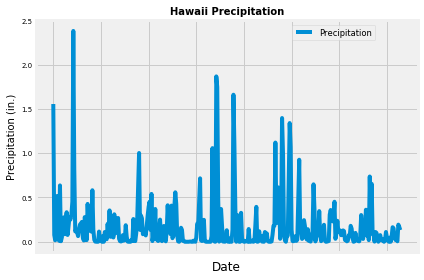

In [16]:

# Use Pandas Plotting with Matplotlib to plot the data

precip_year_data_df.plot(use_index=True, y='Precipitation')

plt.title("Hawaii Precipitation", fontweight='bold',size=10)
plt.ylabel("Precipitation (in.)", size=10)
plt.yticks(size=7)
plt.legend(["Precipitation"],loc=1, fontsize='small', bbox_to_anchor=(.90, 1))
plt.tight_layout()

plt.savefig('Images/Precipitation.png')


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_year_data_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station= most_active[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

[(54.0, 71.66378066378067, 85.0)]

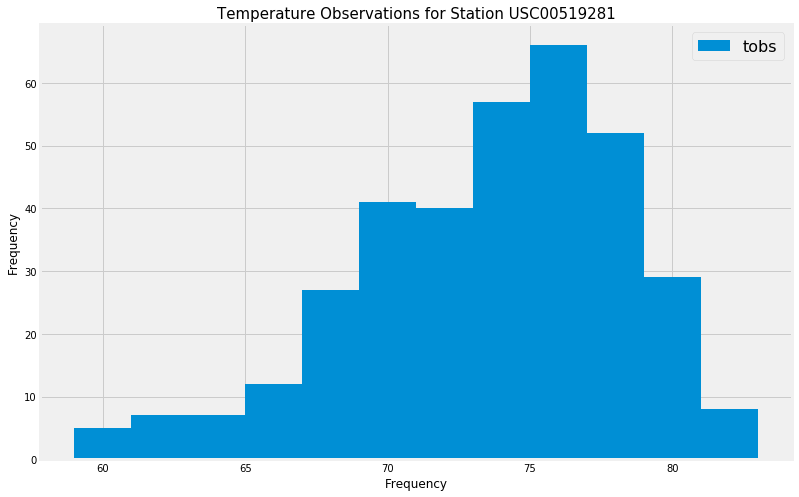

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_obs = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= year_ago).all()
temperature_obs_df = pd.DataFrame(temperature_obs)
temperature_obs_df.set_index('station', inplace=True)

temperature_obs_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid(True)
plt.title("Temperature Observations for Station " + most_active_station, fontsize=15)
plt.xlabel("Frequency", fontsize=12)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)

plt.savefig('Images/Station_Temp_Obs.png')


In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-02-28', '2017-03-05')
trip_results

[(64.0, 72.02777777777777, 78.0)]

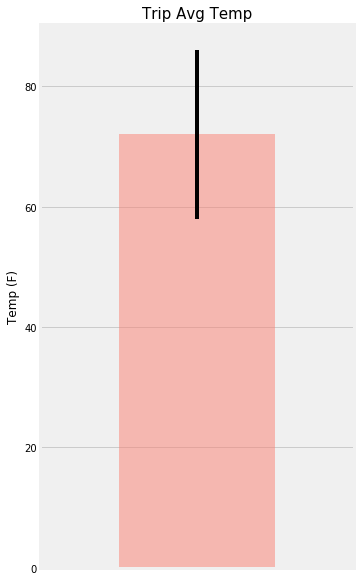

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
tmin_tmax= trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']

avg_temp.plot(kind='bar', yerr=tmin_tmax, figsize=(5,10), alpha=0.5, color='salmon')
plt.title("Trip Avg Temp", fontsize=15)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid(True)

plt.savefig('Images/Trip_Temp.png')

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



trip_precip_by_station_df=pd.DataFrame(session.query(Station.station, Station.name, Station.latitude,
                                                     Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                                       filter(Station.station==Measurement.station).\
                                       filter('2017-02-28'<= Measurement.date, Measurement.date <= '2017-03-05').\
                                       group_by(Measurement.station).all(), columns=['Station', 'Name', 'Latitude', 'Longitude','Elevation', 'Precipitation'])

trip_precip_by_station_df.set_index('Station', inplace=True)
trip_precip_by_station_df

,Name,Latitude,Longitude,Elevation,Precipitation
Station,,,,,
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.45
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.16
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.07
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.72
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.74
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [35]:
last_obs_date=session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first().date
    
year_ago = dt.datetime.strptime(last_obs_date, '%Y-%m-%d') - dt.timedelta(days=365)
yr_precip_year_query=session.query(Measurement.date, Measurement.prcp).\
                            filter(Measurement.date >= year_ago).\
                            all()

yr_precip_query_results = dict(yr_precip_year_query)
print(yr_precip_query_results)

{'2016-08-24': 1.45, '2016-08-25': 0.11, '2016-08-26': 0.01, '2016-08-27': None, '2016-08-28': 2.07, '2016-08-29': 0.9, '2016-08-30': 0.05, '2016-08-31': 2.46, '2016-09-01': 0.01, '2016-09-02': 0.03, '2016-09-03': 1.0, '2016-09-04': 0.44, '2016-09-05': 0.18, '2016-09-06': 1.0, '2016-09-07': 1.35, '2016-09-08': 0.15, '2016-09-09': 0.35, '2016-09-10': 1.16, '2016-09-11': 0.6, '2016-09-12': 1.04, '2016-09-13': 1.2, '2016-09-14': 6.7, '2016-09-15': 3.35, '2016-09-16': 0.61, '2016-09-17': 0.23, '2016-09-18': 0.42, '2016-09-19': 0.25, '2016-09-20': 0.43, '2016-09-21': 1.02, '2016-09-22': 0.75, '2016-09-23': 0.33, '2016-09-24': 0.27, '2016-09-25': 0.04, '2016-09-26': 1.02, '2016-09-27': 1.0, '2016-09-28': 0.05, '2016-09-29': 1.49, '2016-09-30': 0.38, '2016-10-01': 1.02, '2016-10-02': 0.61, '2016-10-03': 0.46, '2016-10-04': 3.46, '2016-10-05': 0.81, '2016-10-06': 0.04, '2016-10-07': 0.01, '2016-10-08': 0.04, '2016-10-09': 0.0, '2016-10-10': 0.0, '2016-10-11': 0.35, '2016-10-12': 0.02, '2016-10